# Create and Update Mask Demo

Important update the colab link:
[Colab Link](https://colab.research.google.com/github/casangi/astroviper/blob/main/docs/core_tutorials/image_analysis/make_mask.ipynb)

This notebook demonstrates how to create and update mask image using `make_mask` function. The function takes xds images as inputs and returns xds mask image, optionally to a disk file in zarr or CASA image format (using xradio write_image function). Current implementation is focused on PB based mask for deconvolution but could be more generalized in the future to support different use cases. 

---

## API

In [1]:
from astroviper.core.image_analysis.make_mask import make_mask
make_mask?

Signature:
make_mask(
    input_image: xarray.core.dataarray.DataArray,
    pb_threshold: float,
    target_image: xarray.core.dataarray.DataArray = None,
    apply_on_target: bool = False,
    combine_mask: bool = False,
    output_image_name: str = '',
    output_format: str = 'zarr',
)
Docstring:
Create or update mask image

Parameters:
input_image : xarray.DataArray
    Input image name (assume pb image for now)
pb_threshold : float
    PB cutoff with respect to the peak value
target_image : xarray.DataArray
    Target image to the generated mask to be used
    to check dimensions and existing mask
apply_on_target : boolean
    Whether to apply the mask on target_image (default: False)
combine_mask : boolean
    Whether to combine with existing mask in target_image (default: False)
output_image_name : str (optional)
    Output mask image name

Returns:
    xarray.Dataset
    Boolean array stored in the data variable 'MASK' in the xradio image
    if apply_on_target is True, the ret

---
## Notes

- Input image data are assumed to be in xradio image format
- Some changes later on expected as the image 
- When data variable MASK0 is detected it assumes the mask data is from a CASA image and reverse True/False definiton (True = good pixels, False = bad) 
- This function is currently limited to create/update PB threshold based mask but 
---


## Install AstroVIPER

Skip this cell if you don't want to install the latest version of AstroVIPER.

In [2]:
from importlib.metadata import version
import os

try:
    os.system("pip install --upgrade astroviper")

    import astroviper

    print("Using astroviper version", version("astroviper"))

except ImportError as exc:
    print(f"Could not import astroviper: {exc}")

Using astroviper version 0.0.30


### Import additional modules/functions used in this notebook

In [3]:
from xradio.image import read_image, write_image
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

## Example 1
Starting from a CASA pb image and generate a stand alone xds mask image

### Download Data

In [4]:
from toolviper.utils.data import download, update
update()
#download(file="twhya_selfcal_11chans_lsrk_robust_0.5_niter_0.psf")

[2025-10-28 10:17:59,133]  WARNING    viperlog:  File exists: /Users/ttsutsum/miniforge3/envs/vipertest/lib/python3.12/site-packages/toolviper/utils/data/.cloudflare 
[2025-10-28 10:17:59,135]     INFO    viperlog:  Updating file metadata information ...  


Output()

In [5]:
from xradio.image import read_image
pb_xds = read_image(infile="cube-hogbom.pb", chunks={"l":25, "m":25} )

[2025-10-28 10:18:00,393]     INFO    viperlog:  J2000 found as system reference frame in CASA image This corresponds to fk5(equinox="j2000") in astropy. Metadata will be written appropriately 
Successful readonly open of default-locked table cube-hogbom.pb: 1 columns, 1 rows
[2025-10-28 10:18:00,405]     INFO    viperlog:  J2000 found as native reference frame in CASA image This corresponds to fk5(equinox="j2000") in astropy. Metadata will be written appropriately 


In [6]:
target_xds= read_image(infile="cube-hogbom.residual", chunks={"l":25, "m":25} )


[2025-10-28 10:18:00,421]     INFO    viperlog:  J2000 found as system reference frame in CASA image This corresponds to fk5(equinox="j2000") in astropy. Metadata will be written appropriately 
Successful readonly open of default-locked table cube-hogbom.residual: 1 columns, 1 rows
[2025-10-28 10:18:00,432]     INFO    viperlog:  J2000 found as native reference frame in CASA image This corresponds to fk5(equinox="j2000") in astropy. Metadata will be written appropriately 


#### Plot input images

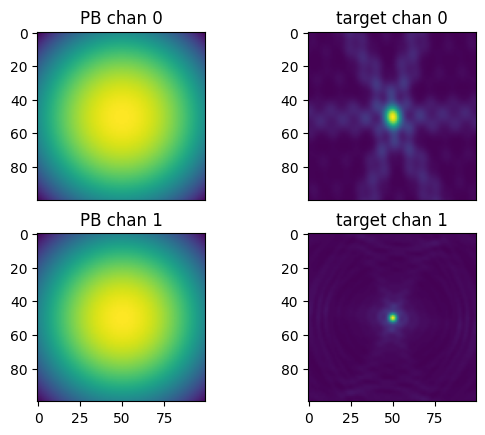

In [7]:
fig, axes = plt.subplots(2,2)
for i in range(2):
    data_sel = {'time':0, 'frequency':i, 'polarization':0}
    pb_data = pb_xds.SKY.isel(data_sel).compute().squeeze()
    target_data = target_xds.SKY.isel(data_sel).compute().squeeze()
    im1 = axes[i,0].imshow(pb_data, cmap='viridis')
    if i==0:
        axes[0,0].xaxis.set_visible(False)
        axes[0,1].xaxis.set_visible(False)
    axes[i,0].set_title(f'PB chan {i}')
    im2 = axes[i,1].imshow(target_data, cmap='viridis')
    axes[i,1].set_title(f'target chan {i}')
plt.show()

### Create PB mask by applying threshold 

In [8]:
mask_xds = make_mask(input_image=pb_xds, pb_threshold=0.9, target_image=target_xds)

The mask data is stored in MASK data variable

In [9]:
mask_xds

<xarray.Dataset> Size: 182kB
Dimensions:          (time: 1, frequency: 2, polarization: 1, l: 100, m: 100)
Coordinates:
  * time             (time) float64 8B 5.479e+04
  * frequency        (frequency) float64 16B 1e+09 2e+09
  * polarization     (polarization) <U1 4B 'I'
    velocity         (frequency) float64 16B 3.373e+03 -2.998e+08
  * l                (l) float64 800B 0.001939 0.0019 ... -0.001862 -0.0019
  * m                (m) float64 800B -0.001939 -0.0019 ... 0.001862 0.0019
    right_ascension  (l, m) float64 80kB 5.236 5.236 5.236 ... 5.231 5.231 5.231
    declination      (l, m) float64 80kB 0.709 0.709 0.7091 ... 0.7128 0.7128
Data variables:
    MASK             (time, frequency, polarization, l, m) bool 20kB dask.array<chunksize=(1, 2, 1, 25, 25), meta=np.ndarray>

#### Plot mask data for confirmation

In [10]:
# Extract numpy mask data
data_sel = {'time':0, 'frequency':1, 'polarization':0}
mask_data = mask_xds.MASK.isel(data_sel).data.compute().squeeze()

In [11]:
mask_data

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(100, 100))

In [12]:
# Number of True in the mask
np.sum(mask_data)

np.int64(3313)

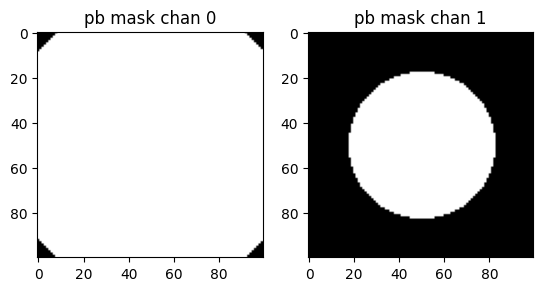

In [13]:
# input image has two channels, plot both channel's mask
fig, axes = plt.subplots(1,2)
for i in range(2):
    data_sel = {'time':0, 'frequency':i, 'polarization':0}
    mask_data = mask_xds.MASK.isel(data_sel).compute().squeeze()
    im1 = axes[i].imshow(mask_data, cmap='gray')
    axes[i].set_title(f'pb mask chan {i}')
plt.show()

### Example 2: Combining with the existing mask

#### Add the mask from Example 1 to target xds manually

In [14]:
# Merge target_xds and mask_xds
target_xds_merged = xr.merge([target_xds, mask_xds])

When converted the CASA image with xradio.read_image, the internal mask in the image is stored as MASKO

In [15]:
target_xds_merged

<xarray.Dataset> Size: 282kB
Dimensions:          (time: 1, frequency: 2, polarization: 1, l: 100, m: 100,
                      beam_param: 3)
Coordinates:
  * time             (time) float64 8B 5.479e+04
  * frequency        (frequency) float64 16B 1e+09 2e+09
  * polarization     (polarization) <U1 4B 'I'
    velocity         (frequency) float64 16B 3.373e+03 -2.998e+08
  * l                (l) float64 800B 0.001939 0.0019 ... -0.001862 -0.0019
  * m                (m) float64 800B -0.001939 -0.0019 ... 0.001862 0.0019
    right_ascension  (l, m) float64 80kB 5.236 5.236 5.236 ... 5.231 5.231 5.231
    declination      (l, m) float64 80kB 0.709 0.709 0.7091 ... 0.7128 0.7128
  * beam_param       (beam_param) <U5 60B 'major' 'minor' 'pa'
Data variables:
    SKY              (time, frequency, polarization, l, m) float32 80kB dask.array<chunksize=(1, 2, 1, 25, 25), meta=np.ndarray>
    MASK0            (time, frequency, polarization, l, m) bool 20kB dask.array<chunksize=(1, 2, 1, 25, 25), meta=np.ndarray>
    MASK             (time, frequency, polarization, l, m) bool 20kB dask.array<chunksize=(1, 2, 1, 25, 25), meta=np.ndarray>
Attributes:
    direction:  {'reference': {'attrs': {'frame': 'fk5', 'type': 'sky_coord',...

#### Check current active_mask attribute and set to the new mask ('MASK')
The 'active_mask' attribute in SKY data variable indicates which mask to be used. So modify to point to the new mask.

In [16]:
target_xds_merged["SKY"].attrs["active_mask"]

'MASK0'

In [17]:
target_xds_merged["SKY"].attrs["active_mask"] = "MASK"

In [28]:
mask_xds_2 = make_mask(input_image=pb_xds, pb_threshold=0.85, target_image=target_xds_merged, combine_mask=True)

#### Combine masks
Now try to use this xds as a target image and create a new mask with combine_mask = True.
The combine_mask = True will take AND of pb threshold and existing mask in the target image. 

In [29]:
mask_xds_2.data_vars

Data variables:
    MASK     (time, frequency, polarization, l, m) bool 20kB dask.array<chunksize=(1, 2, 1, 25, 25), meta=np.ndarray>

Since currently make_mask only allows PB threshold based masking, in this example, combining the 0.85 threshold mask and the existing (0.9) pb mask yields the same mask as before. 

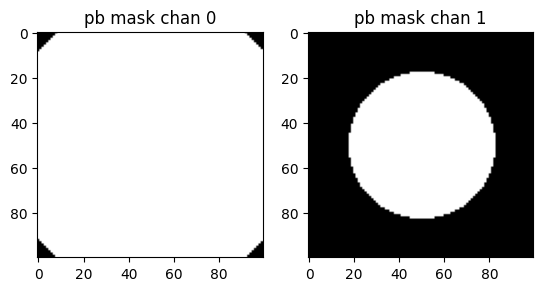

In [30]:
fig, axes = plt.subplots(1,2)
for i in range(2):
    data_sel = {'time':0, 'frequency':i, 'polarization':0}
    mask_data = mask_xds_2.MASK.isel(data_sel).compute().squeeze()
    im1 = axes[i].imshow(mask_data, cmap='gray')
    axes[i].set_title(f'pb mask chan {i}')
plt.show()

### Example 3: Apply a mask to target image

In [22]:

target_with_mask_xds = make_mask(input_image=pb_xds, pb_threshold=0.85, target_image=target_xds, apply_on_target=True)

In [23]:
target_with_mask_xds

<xarray.Dataset> Size: 282kB
Dimensions:          (time: 1, frequency: 2, polarization: 1, l: 100, m: 100,
                      beam_param: 3)
Coordinates:
  * time             (time) float64 8B 5.479e+04
  * frequency        (frequency) float64 16B 1e+09 2e+09
  * polarization     (polarization) <U1 4B 'I'
    velocity         (frequency) float64 16B 3.373e+03 -2.998e+08
  * l                (l) float64 800B 0.001939 0.0019 ... -0.001862 -0.0019
  * m                (m) float64 800B -0.001939 -0.0019 ... 0.001862 0.0019
    right_ascension  (l, m) float64 80kB 5.236 5.236 5.236 ... 5.231 5.231 5.231
    declination      (l, m) float64 80kB 0.709 0.709 0.7091 ... 0.7128 0.7128
  * beam_param       (beam_param) <U5 60B 'major' 'minor' 'pa'
Data variables:
    SKY              (time, frequency, polarization, l, m) float32 80kB dask.array<chunksize=(1, 2, 1, 25, 25), meta=np.ndarray>
    MASK0            (time, frequency, polarization, l, m) bool 20kB dask.array<chunksize=(1, 2, 1, 25, 25), meta=np.ndarray>
    MASK             (time, frequency, polarization, l, m) bool 20kB dask.array<chunksize=(1, 2, 1, 25, 25), meta=np.ndarray>
Attributes:
    direction:  {'reference': {'attrs': {'frame': 'fk5', 'type': 'sky_coord',...

In [24]:
target_with_mask_xds["SKY"].attrs["active_mask"]

'MASK'